# Exploratory Data Analysis (EDA)

### Data Horizon Selection (MSFT)

- ~1 year of data is insufficient to reliably identify volatility persistence and regime structure, even though mean returns may already appear uncorrelated.

- Very long histories combine heterogeneous market regimes, reducing relevance for modern forecasting.

- Microsoft experienced major leadership and strategic shifts around 2013, after which price and volatility dynamics changed materially.

- Using data from 2014 onward provides sufficient history to study volatility behavior and regime dynamics while remaining representative of the modern business environment.

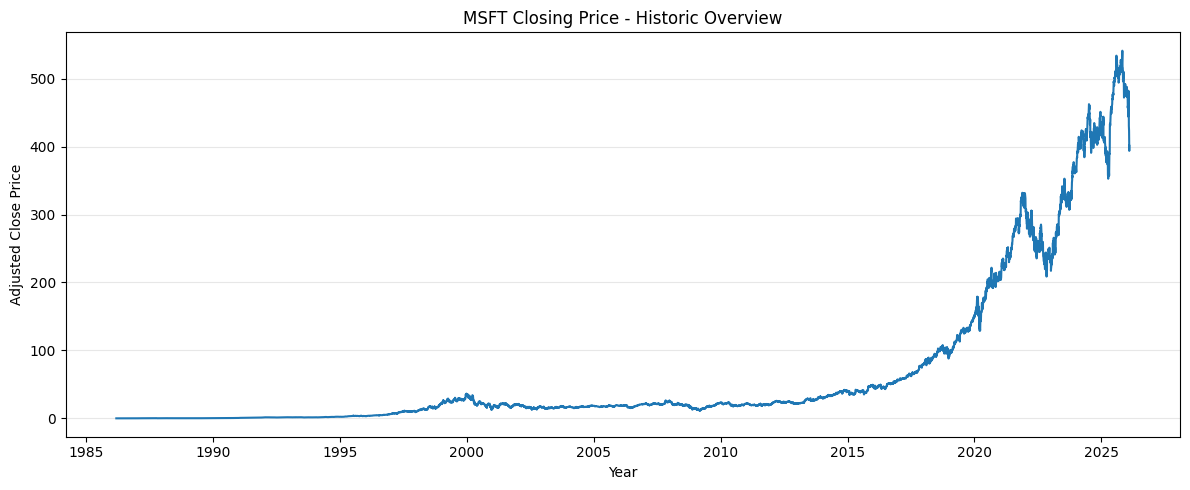

Please also visit [02_eda_analysis_limited_horizon](./02_eda_analysis_limited_horizon.ipynb) the eda analysis performed on limited horizon to better understand the difference and improvement that longer horizon provides. 

Addtionally, the first notebook [01_data_inspection](./01_data_inspection.ipynb) includes data inspection like quality and sanity checks.

For interactive plots of this notebook, please run this notebook locally or use [![Binder]](https://mybinder.org/v2/gh/shashankgarewal/Time-Series-Analysis-Forecasting/HEAD?filepath=notebooks/02_eda_analysis.ipynb)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels as sm

In [2]:
# decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
# stationary
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import ks_2samp
# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
# statistics
from scipy import stats

In [3]:
# for interactive plot
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, HTML 

In [4]:
# fix runtime autoclose in collab
import ipykernel
ipykernel.version_info

(6, 29, 5)

In [5]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

## Data Load and Feature Computation

In [6]:
df = yf.download('MSFT', start="2014-01-01", auto_adjust=True, progress=False)
df.columns = [col[0] for col in df.columns]
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2014-01-02,30.831133,31.030259,30.781351,30.988772,30632200
2014-01-03,30.623713,30.880916,30.366509,30.864322,31134800
2014-01-06,29.976547,30.607107,29.959953,30.573919,43603700
2014-01-07,30.208860,30.275237,30.042923,30.142487,35802800
2014-01-08,29.669588,29.984870,29.520247,29.868714,59971700


In [7]:
df['Return'] = df['Close'].pct_change()
df['LogReturn'] = np.log(df['Close']).diff()
df.describe()

,Close,High,Low,Open,Volume,Return,LogReturn
count,3046.000000,3046.000000,3046.000000,3046.000000,3.046000e+03,3045.000000,3045.000000
mean,194.310452,196.080411,192.375200,194.284090,2.878982e+07,0.000985,0.000845
std,146.491886,147.736469,145.164778,146.528607,1.364411e+07,0.016701,0.016697
min,29.022415,29.769126,28.732019,28.814986,5.855900e+06,-0.147390,-0.159453
25%,56.661406,57.039268,56.270071,56.650174,2.034822e+07,-0.006783,-0.006806
50%,149.624023,150.597250,147.696562,149.272718,2.565885e+07,0.000868,0.000867
75%,299.424973,302.066200,296.906575,299.740147,3.317265e+07,0.009362,0.009318
max,541.057373,553.502444,539.759814,553.283183,2.025224e+08,0.142169,0.132929


## General Data Exploration

### Diagnose date gaps

In [8]:
df.index.diff().value_counts().head()

Date
1 days    2382
3 days     549
4 days      83
2 days      31
Name: count, dtype: int64

In [9]:
# df for gap vs jump relation
analysis_df = df.copy()
analysis_df['GapDays'] = analysis_df.index.to_series().diff().dt.days
analysis_df['AbsJumpInClose'] = analysis_df['Close'].diff().abs()
analysis_df = analysis_df.dropna()

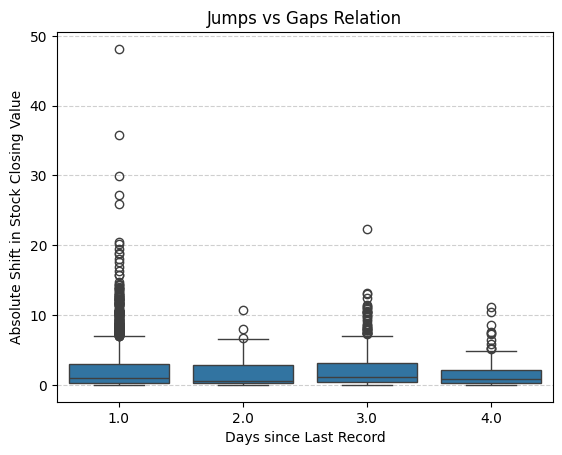

In [10]:
sns.boxplot(data=analysis_df, x = 'GapDays', y = 'AbsJumpInClose')
plt.title('Jumps vs Gaps Relation')
plt.xlabel('Days since Last Record')
plt.ylabel('Absolute Shift in Stock Closing Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [11]:
analysis_df.groupby('GapDays')['AbsJumpInClose'].describe()

,count,mean,std,min,25%,50%,75%,max
GapDays,,,,,,,,
1.0,2382.0,2.290273,3.249962,0.000000,0.326000,0.999092,3.014683,48.130005
2.0,31.0,2.019600,2.817932,0.037422,0.242929,0.632843,2.801239,10.679993
3.0,549.0,2.189050,2.716301,0.000000,0.360554,1.090012,3.076935,22.288086
4.0,83.0,1.905151,2.520613,0.008629,0.239763,0.837799,2.180885,11.092026


* The longer gaps (more than 1 day) doesn't affect the jumps, suggesting no abnormality in stock data. 


* The more outliers in shorter gaps suggest more jumps in close price than large gaps. The consecutive days have higher volatility and are more concerning.

### Distribution

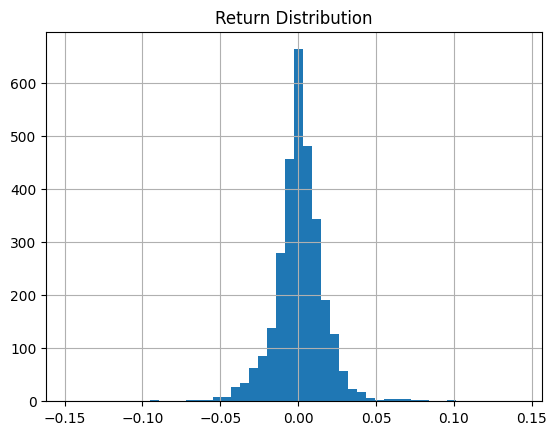

In [12]:
df["Return"].hist(bins=50)
plt.title("Return Distribution")
plt.show()

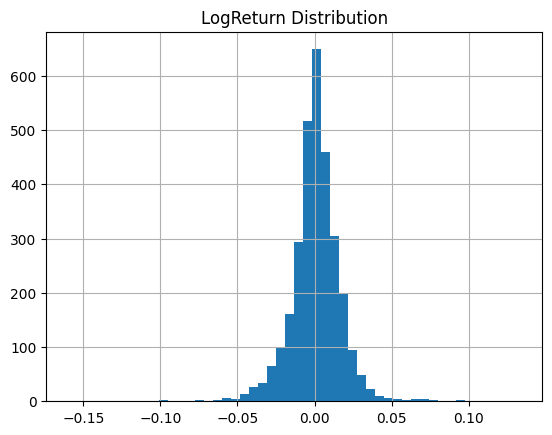

In [13]:
df["LogReturn"].hist(bins=50)
plt.title("LogReturn Distribution")
plt.show()

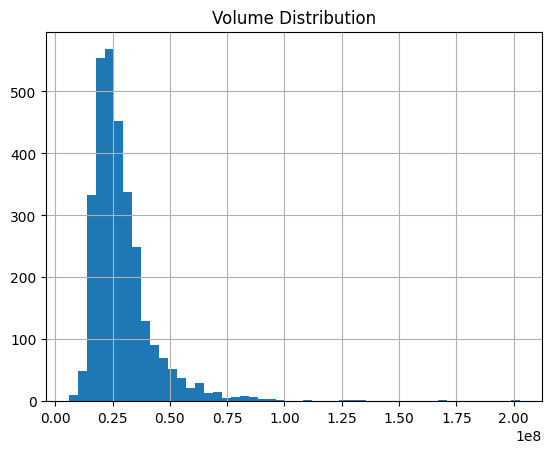

In [14]:
df['Volume'].hist(bins=50)
plt.title('Volume Distribution')
plt.show()

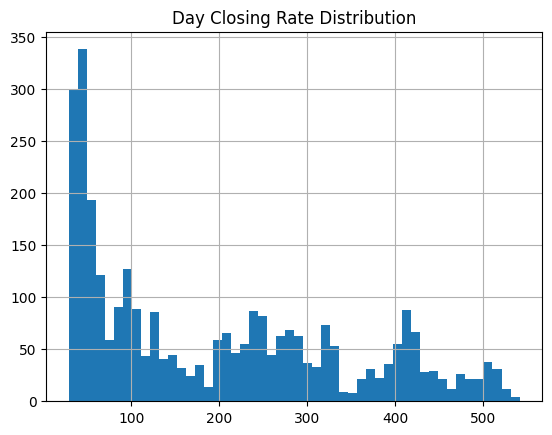

In [15]:
df['Close'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

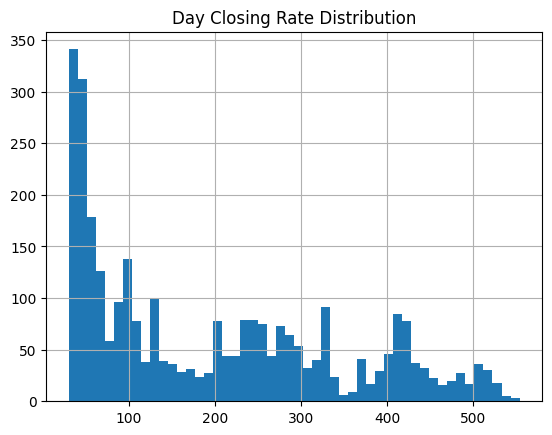

In [16]:
df['High'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

* Stock open and close price show multimodal distribution.
  * Tree-based (XGBoost, Random Forest) and Hidden Markov Model might work better than ARIMA or LSTM that work on sequencial data, or could be effect of trend.
  * Feature Engineering may benefit in sequencial based models
* Return and log of return show normal distribution, better for modeling even ML and DL models
* Volume shows positively skewed distribution

## Exploration Relevant to Forecast

In [17]:
# no of days in 1 year
(df.index.year == 2014).sum()

np.int64(252)

### Decomposition

Decomposition of 1008 days (≈4 years) is used to see meaningful trend/seasonal patterns.

1 months window (≈252/12) as seasonal period is considered for captures minor trends and corrections

1 year (252) as seasonal period for capturing annual level trends.

#### classic decomp - last 1008 days

In [18]:
df.index.date.min()

datetime.date(2014, 1, 2)

In [19]:
def plot_classic_decomp(series, model='additive', period=21):
    decomp = seasonal_decompose(series, model=model, period=period)

    fig = decomp.plot()
    fig.set_size_inches(14, 7)
    fig.suptitle(f'Classic {model} decomposition on [{series.index.date.min()}, {series.index.date.max()}] - {period} days period', fontsize=14, y=1.02)
    fig.subplots_adjust(top=0.92)
    fig.tight_layout()
    plt.show()
    return decomp

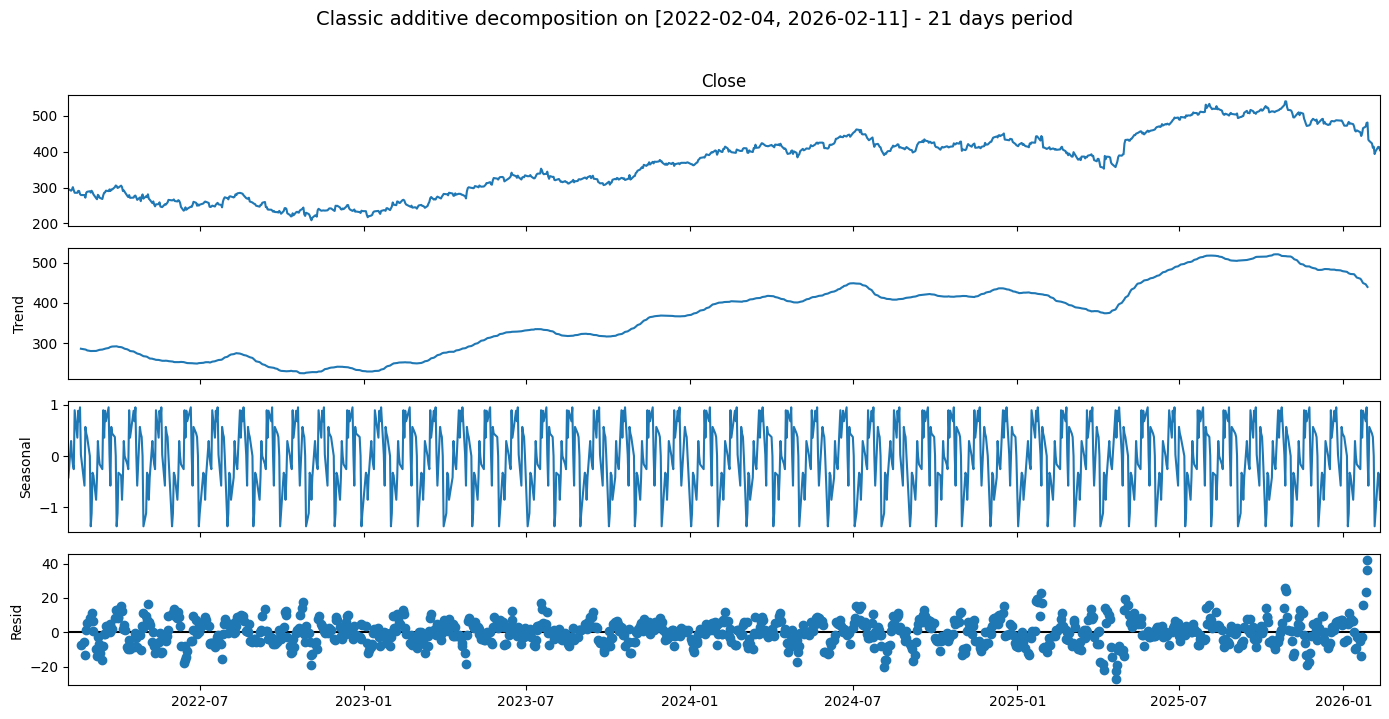

In [20]:
plot_classic_decomp(df['Close'][-1008:], 'additive', 21);

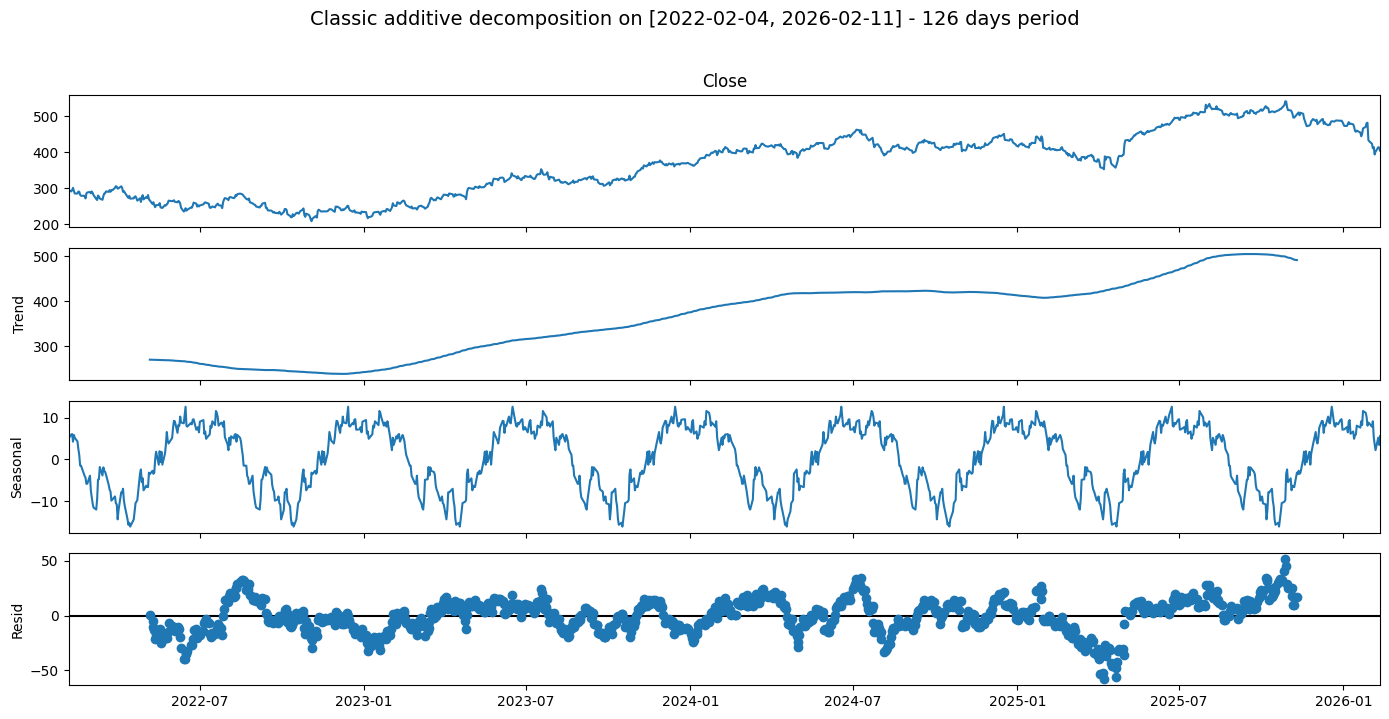

In [21]:
plot_classic_decomp(df['Close'][-1008:], 'additive', 126);

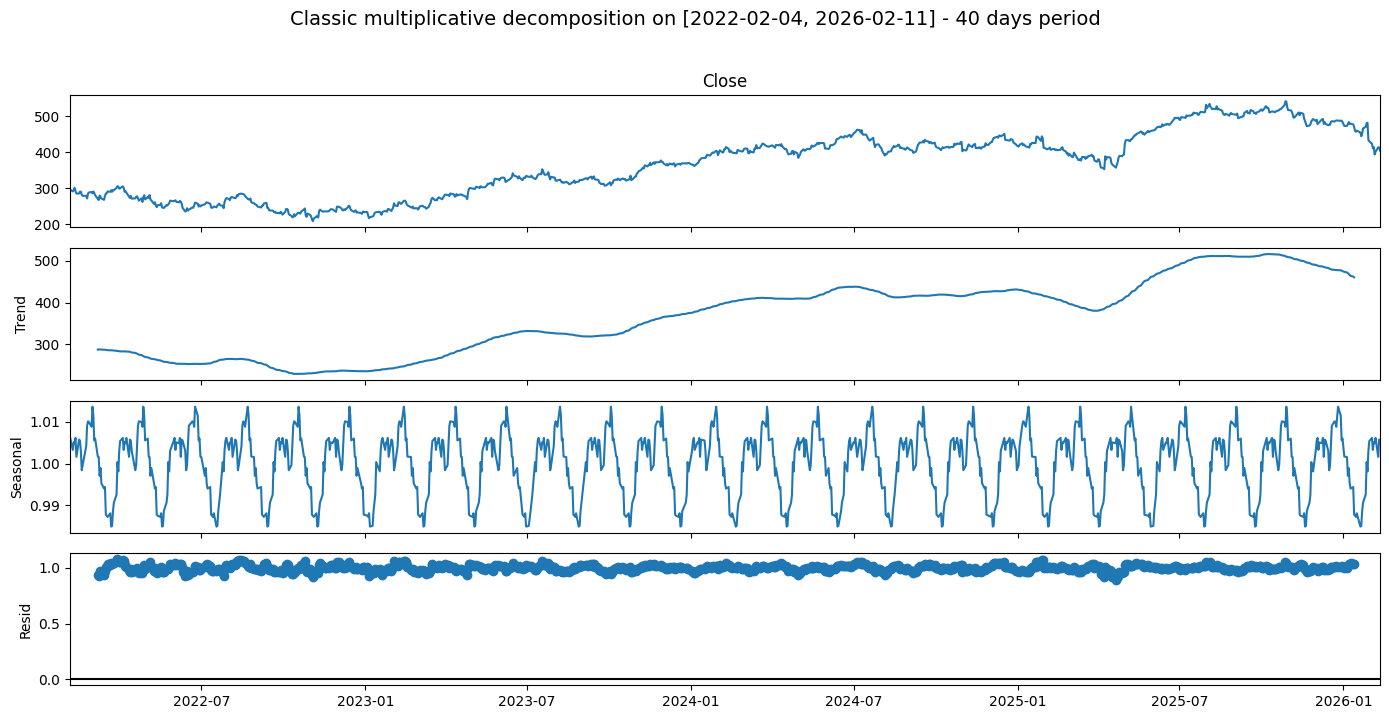

In [22]:
plot_classic_decomp(df['Close'][-1008:], model='multiplicative', period=40);

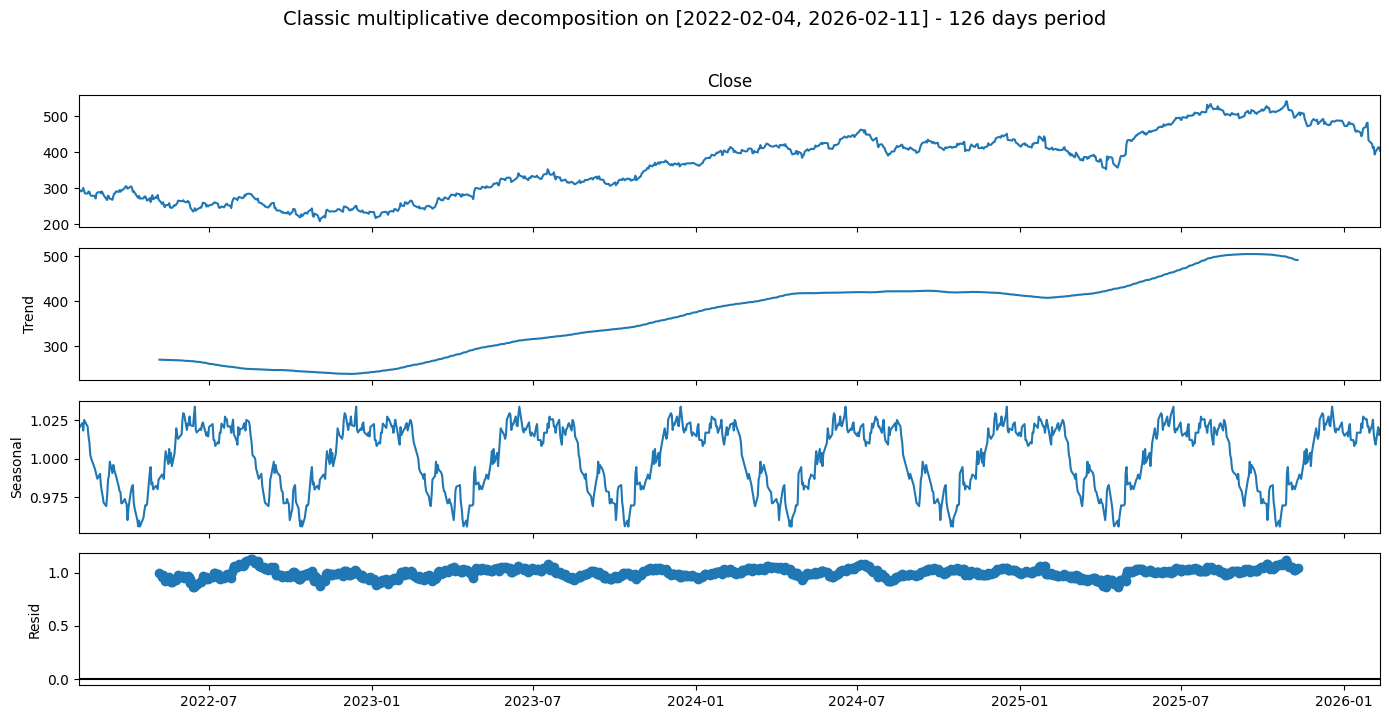

In [23]:
decomp = plot_classic_decomp(df['Close'][-1008:], model='multiplicative', period=126)

In [24]:
print(f"seasonal stats: \n{decomp.seasonal.describe()}\n")
print(f"residual stats: \n{decomp.resid.describe()}")

seasonal stats: 
count    1008.000000
mean        1.000000
std         0.020945
min         0.955976
25%         0.982432
50%         1.003513
75%         1.019510
max         1.033665
Name: seasonal, dtype: float64

residual stats: 
count    882.000000
mean       0.998070
std        0.043183
min        0.861665
25%        0.970239
50%        1.003028
75%        1.028764
max        1.124615
Name: resid, dtype: float64


* Classic decomposition fails to optimially seperate all 3 components, similar to the observations found with [1 year data](./02_eda_analysis_limited_horizon.ipynb)

* In both additive and multiplicative decomposition, the residual remains seasonal pattern information (functionation of ±20 in residual), and more contributing to series with wider fluctuation than seasonal component.

* The short period window (21 days) will be better at capturing recent trend pattern along with , while longer period will be good for understanding general overall growth with time.

#### stl decomp - last 1008 days

In [25]:
# additive decomposition is stl - offers freedom to seasonal component
def plot_stl_decomp(series, period, seasonal):
    stl = STL(series, period=period, seasonal=seasonal, robust=True)
    result = stl.fit()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    ax1.plot(result.trend, color='red')
    ax1.set_title('Trend Component')

    ax2.plot(result.seasonal, color='blue')
    ax2.set_title('Seasonal Component')

    ax3.plot(result.resid, color='green')
    ax3.set_title('Residual Component')

    fig.suptitle(f'STL Decomposition - [{series.index.date.min()}, {series.index.date.max()}]: Period: {period}, Seasonal: {seasonal}')
    fig.set_size_inches(15, 7)
    fig.tight_layout()
    plt.show()
    return result

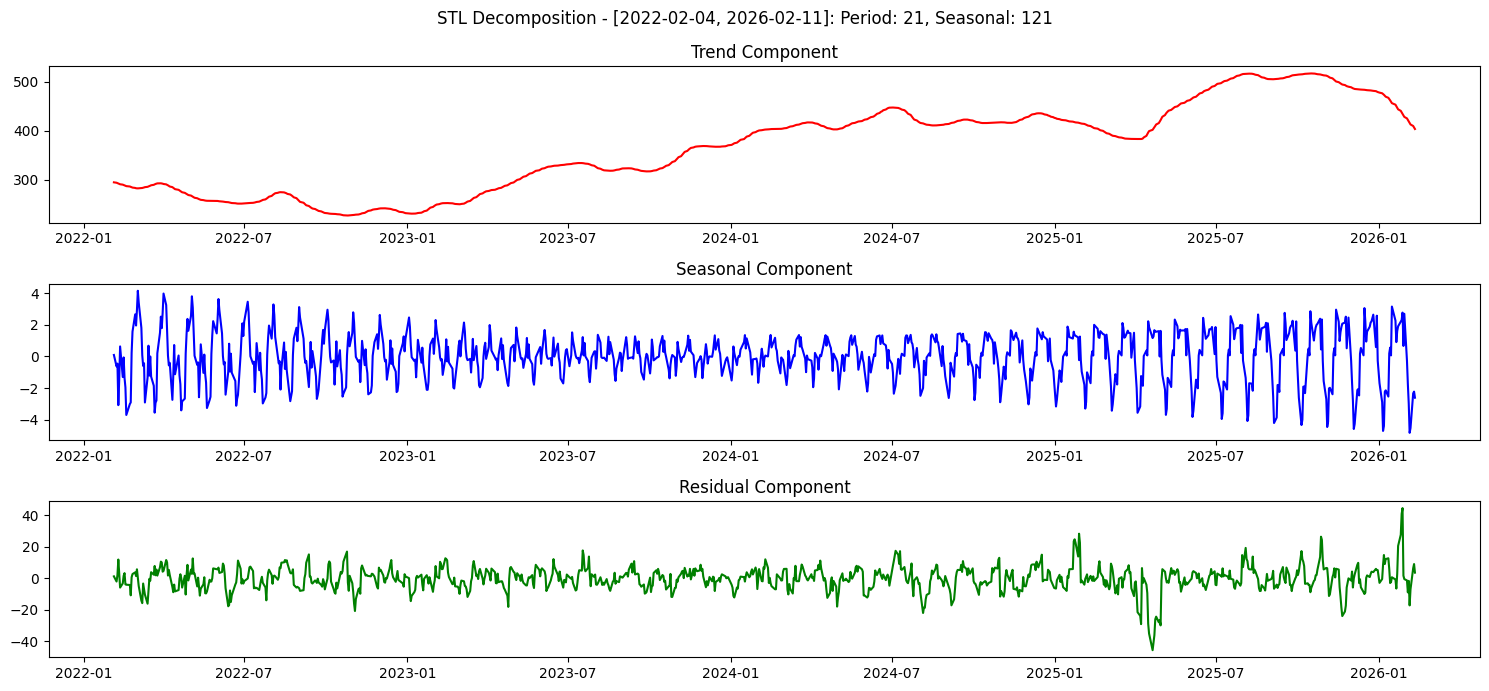

In [26]:
# set STATIC = True, for interactive widget plot
STATIC = True

if not STATIC:
    def plot_stl_wrap(period, seasonal):
        series = df['Close'][-1008:]
        return plot_stl_decomp(series, period=period, seasonal=seasonal)
        
    interact(plot_stl_wrap,
            period=widgets.IntSlider(min=21, max=252, step=5, value=21),
            seasonal=widgets.IntSlider(min=21, max=501, step=2, value=21)
    );
else:
    # GitHub fallback: render a static example 
    plot_stl_decomp(df['Close'][-1008:], period=21, seasonal=121);

For interactive plots, please run this notebook locally or use [![Binder]](https://mybinder.org/v2/gh/shashankgarewal/Time-Series-Analysis-Forecasting/HEAD?filepath=notebooks/02_eda_analysis.ipynb)

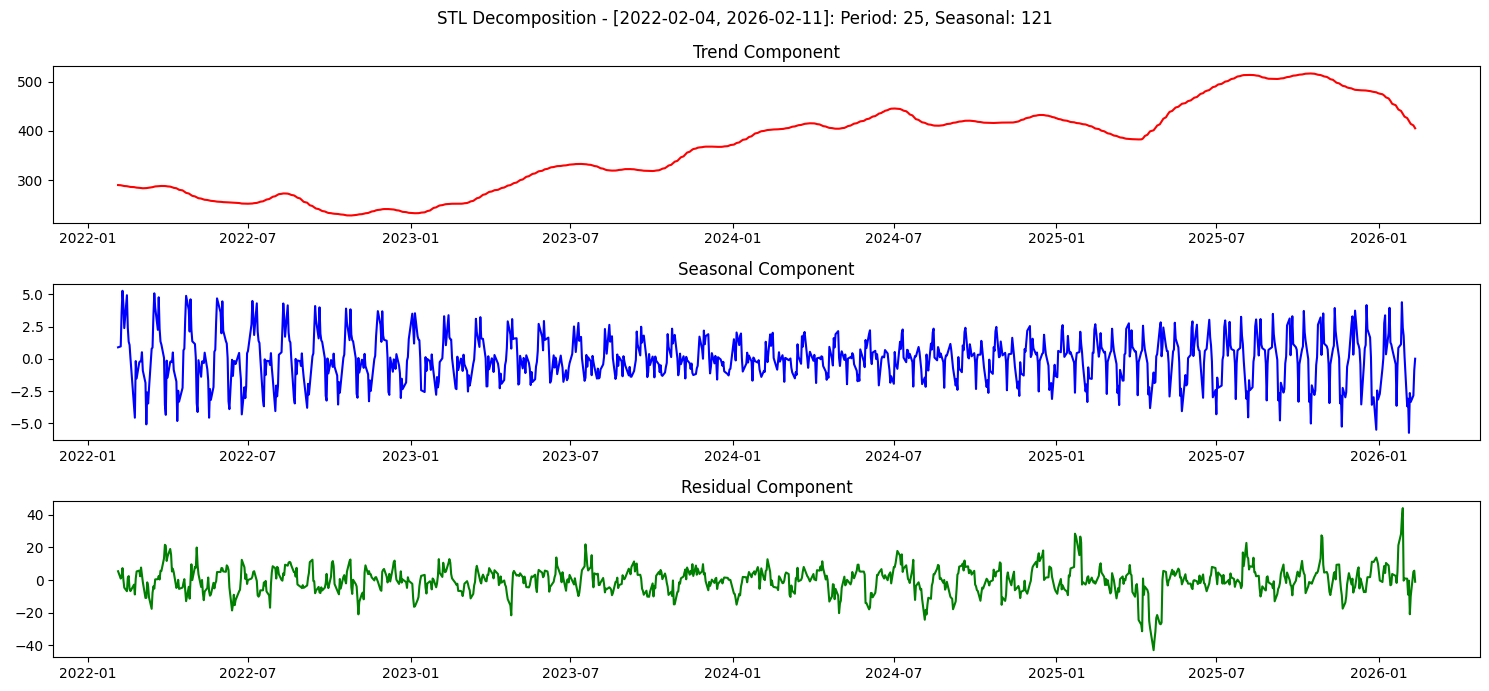

In [27]:
# set STATIC = True, for interactive widget plot
STATIC = True

if not STATIC:
    def plot_stl_wrap(period, seasonal):
        series = np.log(df['Close'])[-1008:]
        return plot_stl_decomp(series, period=period, seasonal=seasonal)
        
    interact(plot_stl_wrap,
            period=widgets.IntSlider(min=21, max=252, step=5, value=21),
            seasonal=widgets.IntSlider(min=21, max=501, step=2, value=21)
    );
else:
    # GitHub fallback: render a static example 
    plot_stl_decomp(df['Close'][-1008:], period=25, seasonal=121);

For interactive plots, please run this notebook locally or use [![Binder]](https://mybinder.org/v2/gh/shashankgarewal/Time-Series-Analysis-Forecasting/HEAD?filepath=notebooks/02_eda_analysis.ipynb)

4 years plot (2022-2026):
* Trend is mostly smooth with changing movement ( drawdown -> recovery -> slide -> recovery -> slowdown/correction?) and represents medium-frequency market behavior. 
* Seasonal component is again weak and unstable, and much smaller amplitude and more symmetric around 0 in comparision to 1 year decomp plot.
* Residual shows volatile clusters (via, high magnitude of random spikes) and not centered around 0 mean. Like 1 year, residual is not white noise and may have pattern and predictable spikes and noise.

* ACF, PACF needed here also for checking further dependence and pattern.

Such residual noises in stock data is normal, usually caused from daily news, events.

#### decomp on full data

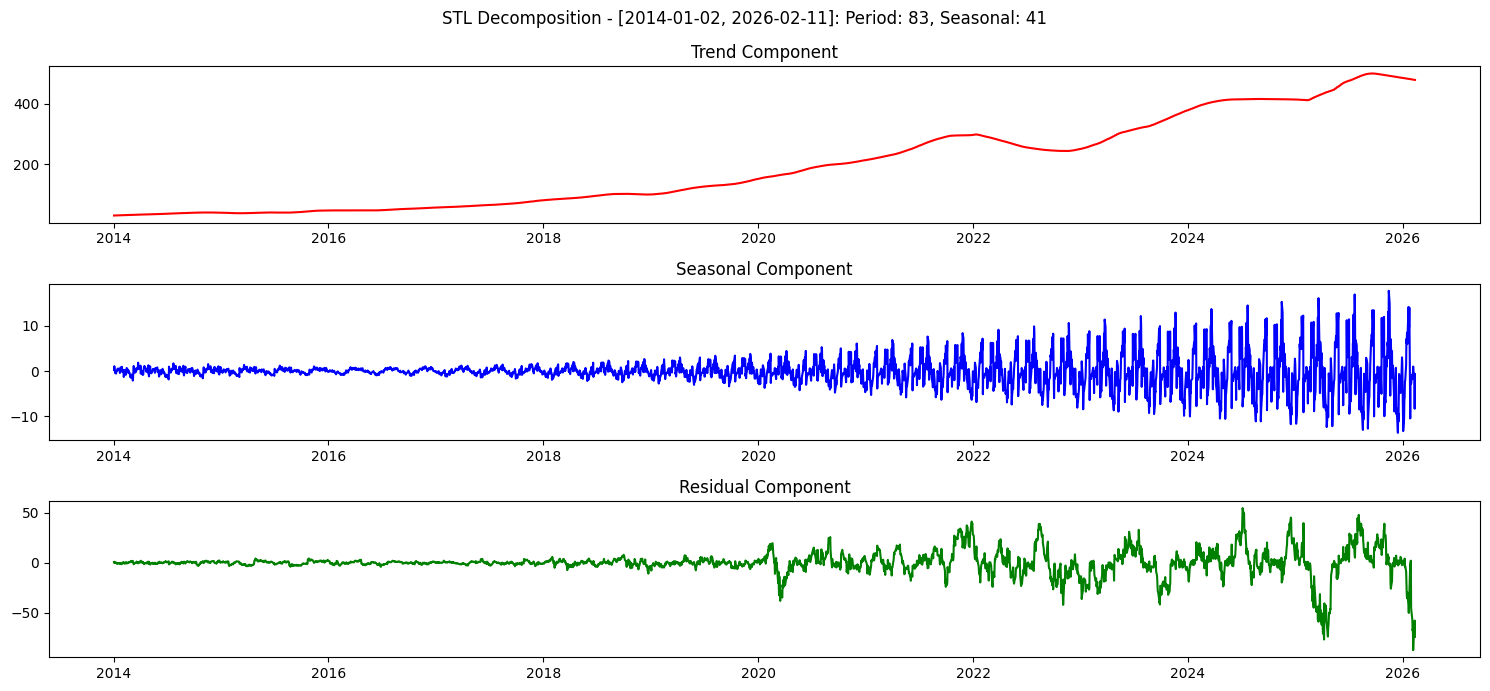

In [28]:
# 91 seasonal period captures 
plot_stl_decomp(df['Close'], 83, 41);

Data from 2014:
* Trends show a monotonic rise in close price, and visible shift in regime: pre-2018 slow growth-mostly flat, post-2019 acceleration, 2022 drawdown, post-2023 recovery, late-2025 drawndown. 
* Major events are correlating with regime change: during 2018, Windows 10 free upgrade ends ➕, Office switched to subscription model ➕. In 2021-2022, ➖ faced legal challenges in deal to acquire a game developer company. In 2023, ➕ collabrated with OpenAI; and in ➖ mid 2024 msft was blamed for security lapses.  
* Suprisingly, Covid 19 lockdown (2020) and following recession doesn't appears to affecting the trend regime.
* Seasonality is increasing with time, bad for forecasting. 
* Residual shows is small during early days, and clearly heteroskedasticity.

Currently, MSFT stock is again showing drawdown trend, likely driven by heavy AI capex outpacing the revenue growth investors expected.

In non-seasonal data like stock price, STL decomp capture vollatility patterns, and not repiting cycle. Seasonal components should not be interpreted and forecasted.

Short windows capture noise, long windows capture structure, but neither creates true seasonality in stock prices.

### Stationarity Check


**Log-Return** provide meaningful benefits over other transformation like return, such as during forecast there will be no intermediate price dependence, closer to normality, addition instead of multiply during reconstruction of Close price.

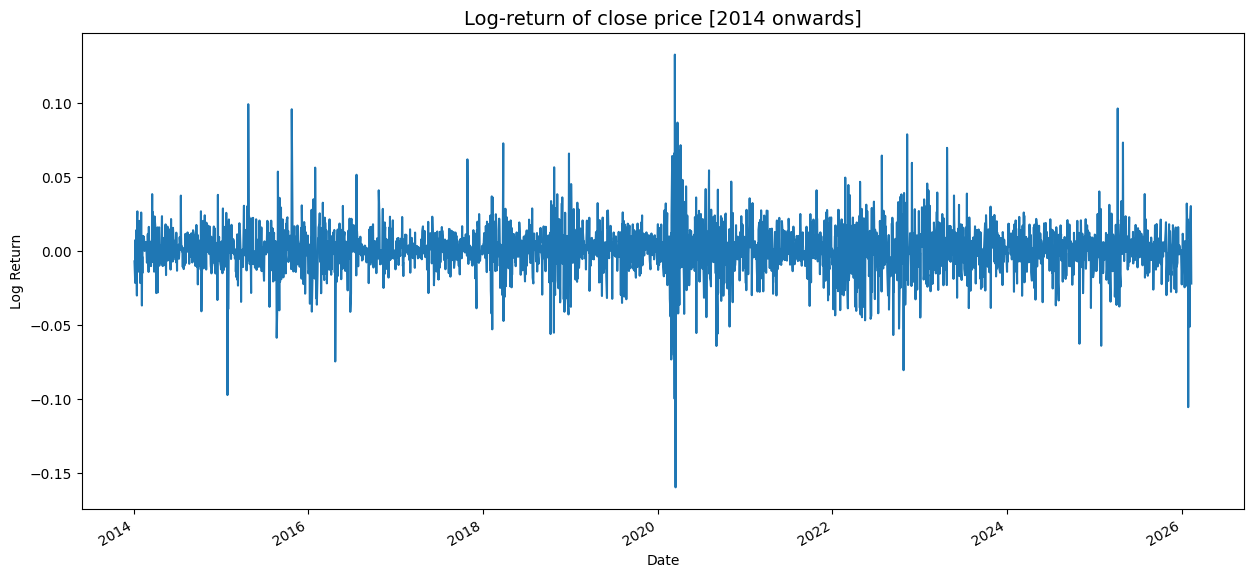

In [29]:
df['LogReturn'].plot(figsize=(15, 7))
plt.ylabel('Log Return')
plt.title('Log-return of close price [2014 onwards]', fontsize=14)
plt.show()

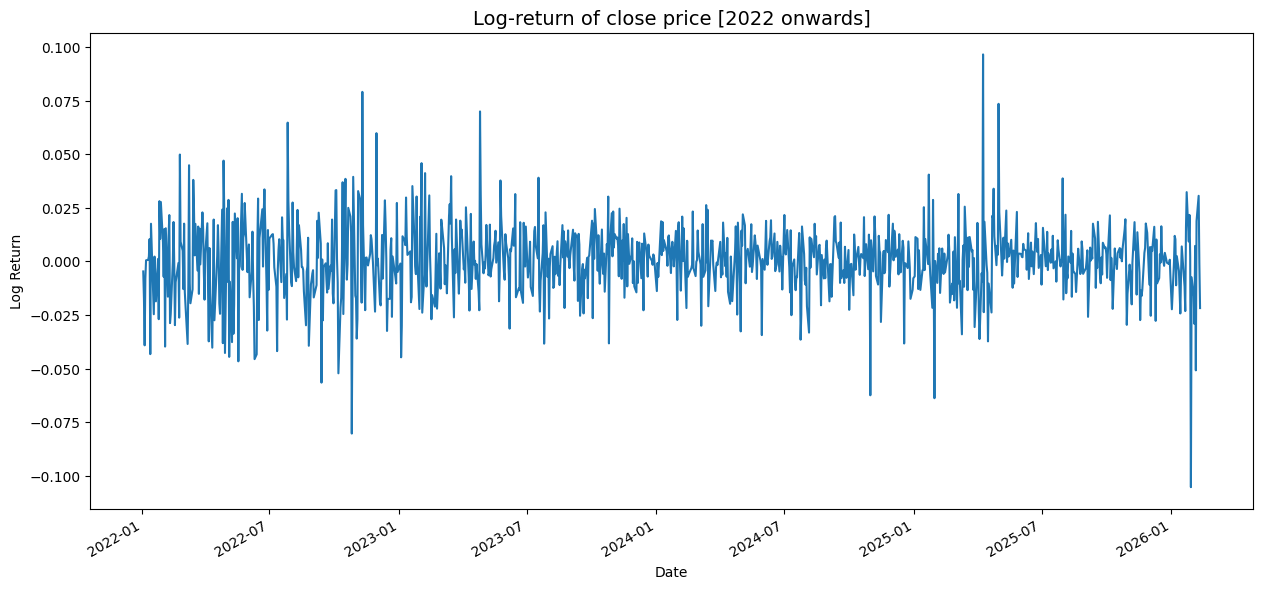

In [30]:
limit = df['LogReturn'].index.year >= 2022
df['LogReturn'][limit].plot(figsize=(15, 7))
plt.ylabel('Log Return')
plt.title('Log-return of close price [2022 onwards]', fontsize=14)
plt.show()

The close‑price trend showed noticeable ups and downs at monthly and annual view, but the daily change are largely small with no strong direction or short‑term pattern. The log-return visually looks stationary and also noisy. 

#### weak stationary test

In [31]:
## augmented dickey fuller - check mean/trend condition
## null hypothesis; non-stationary (has root unit, Φ = 1; Φ not < 1) 
def get_adf(series, name=""):
    adf_result = adfuller(series.dropna())
    print(f"adfuller test on {name}: {name} stationary if p < 0.05 | stat < critical values\n")
    adf_result = adfuller(df['Return'].dropna())

    print("p-value:", adf_result[1])
    print("adf stat:", adf_result[0])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'{key}: {round(value, 3)}')

## kpss test - can check both (trend/trend+seasonal) condition
## null hypothesis: stationary series     
def get_kpss(series, literal='ct', name=""):
    kpss_result = kpss(series.dropna(), literal)
    print(f"kpss test on {name}: {name} stationary if p > 0.05 AND stat < critical values\n")
    print("p-value:", kpss_result[1])
    print("kpss stat:", kpss_result[0])
    print('Critical Values for Return:')
    for key, value in kpss_result[3].items():
      print(f'{key}: {round(value, 3)}')
      
      
## 

In [32]:
# ad fuller test on full data
get_adf(df['LogReturn'], "log return")

adfuller test on log return: log return stationary if p < 0.05 | stat < critical values

p-value: 0.0
adf stat: -19.191167008159255
Critical Values:
1%: -3.433
5%: -2.862
10%: -2.567


In [33]:
get_kpss(df['LogReturn'], "ct", "log return")

kpss test on log return: log return stationary if p > 0.05 AND stat < critical values

p-value: 0.1
kpss stat: 0.061843844541687044
Critical Values for Return:
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216


#### strict stationarity condition

In [34]:
## ks test - check join distribution condition
## null hyphothesis: (constant join distribution) stationary condition 
def get_ks(series, name=""):
    print(f"ks test on {name}: stationary if p > 0.05\n")
    split = len(series.dropna()) // 2
    stat, pvalue = ks_2samp(series.dropna()[0:split],
                            series.dropna()[split:-1])
    print(f"KS Statistic: {stat:.4f}")
    print(f"P-value: {pvalue:.4f}")

In [35]:
get_ks(df['LogReturn'], 'log-return')

ks test on log-return: stationary if p > 0.05

KS Statistic: 0.0696
P-value: 0.0012


Log-Return Stationarity Check:

* The adf and kpss test on full data confirm that the log-return is stationary, while the ~1 year data p-values were in borderline for rejection.
* KS test resulted p-value less than 0.05; series has different join distribution and series is not strict stationary. This is because there is more data to check for the skewness, regime changes, volatility clustering, and boundary points, unlike ~1 year which failed to reject stationarity hypothesis.

Conclusion: The LogReturn series is weak stationary.

### Autocorrelation
linear correlation of the feature with its own past values

#### Close price statistics reverify

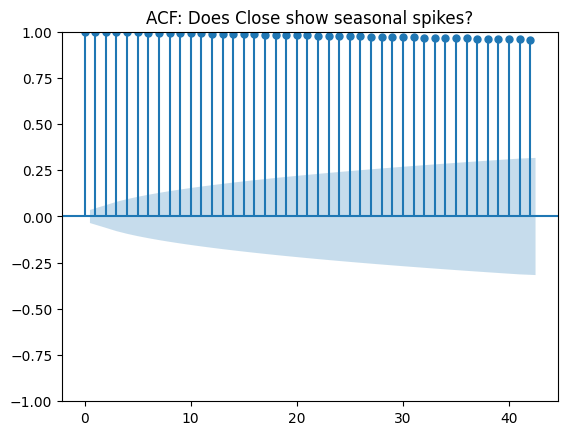

In [36]:
plot_acf(df["Close"].dropna(), lags=42)
plt.title("ACF: Does Close show seasonal spikes?")
plt.show()

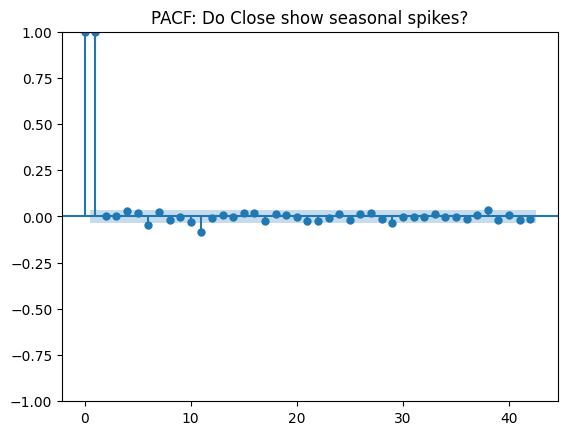

In [37]:
plot_pacf(df["Close"].dropna(), lags=42)
plt.title("PACF: Do Close show seasonal spikes?")
plt.show()

ACF of close price shows gradual decay, series with trends; and no significant spikes at lag intervals in ACF and PACF confirm no seasonality in close price. 

#### Check Log-Return lag structure and model order

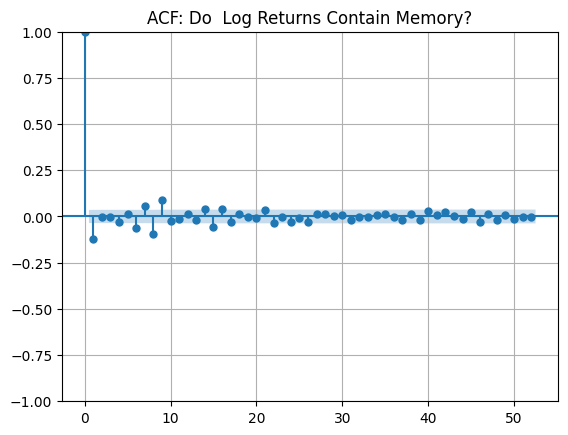

In [38]:
plot_acf(df["LogReturn"].dropna(), lags=52)
plt.title("ACF: Do  Log Returns Contain Memory?")
plt.grid()
plt.show()

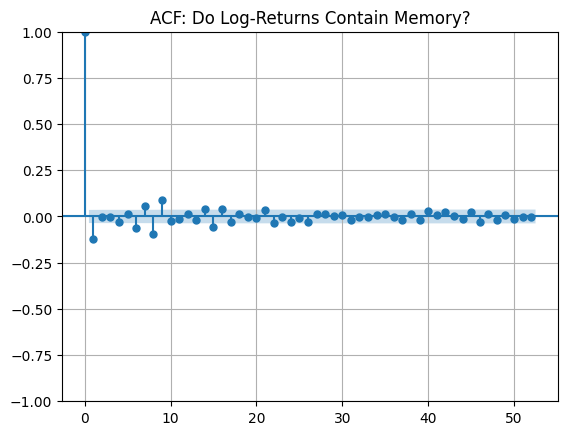

In [39]:
plot_acf(df["LogReturn"].dropna(), lags=52)
plt.title("ACF: Do Log-Returns Contain Memory?")
plt.grid()
plt.show()

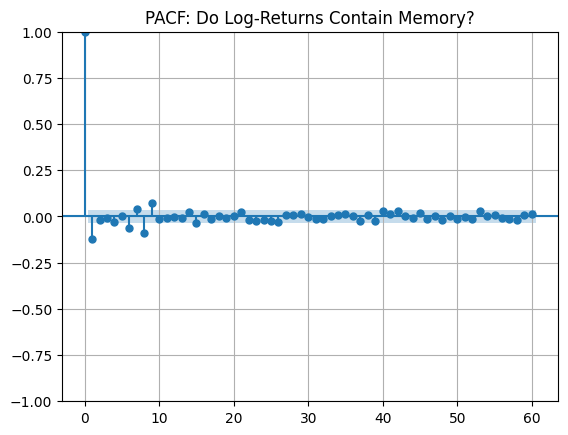

In [40]:
plot_pacf(df["LogReturn"].dropna(), lags=60)
plt.grid()
plt.title("PACF: Do Log-Returns Contain Memory?")
plt.show()

1 to 60 lags p-values: 
 [4.21999257e-11 3.48084240e-10 1.79797329e-09 2.40662410e-09
 7.34356750e-09 8.72564592e-11 4.63385205e-12 4.59113912e-17
 1.53710909e-21 2.45695417e-21 7.47523564e-21 2.18252639e-20
 4.55406737e-20 1.55719585e-20 5.52901132e-22 2.27354657e-22
 2.02805436e-22 4.91807919e-22 1.39789164e-21 3.76841118e-21
 2.11988047e-21 8.92645567e-22 2.35853644e-21 1.82922087e-21
 4.39100999e-21 4.17638925e-21 8.76843872e-21 1.68174736e-20
 3.99982707e-20 8.74245066e-20 1.14770504e-19 2.57408314e-19
 5.88101678e-19 1.18954516e-18 2.27334405e-18 4.96158736e-18
 6.57290805e-18 1.17824449e-17 1.51878577e-17 1.30680225e-17
 2.40643009e-17 2.81562813e-17 5.72645906e-17 9.88324608e-17
 8.78962753e-17 6.85144490e-17 1.16169065e-16 1.35727253e-16
 2.31990481e-16 3.88597623e-16 7.33746273e-16 1.37629076e-15
 1.91275510e-15 2.82696756e-15 5.18344164e-15 9.36209457e-15
 1.01140430e-14 1.44029757e-14 2.23337038e-14 3.85951605e-14]


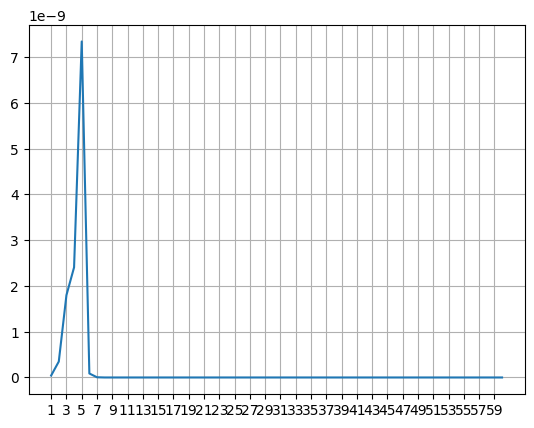

In [41]:

jung_result = acorr_ljungbox(df['LogReturn'].dropna(), lags=60, return_df=True)
print('1 to 60 lags p-values: \n', jung_result['lb_pvalue'].values)
jung_result['lb_pvalue'].plot()
plt.xticks(np.arange(1, 60, 2))
plt.grid()
plt.show()

ACF and PACF are mostly inside the confidence band, indicating the absence of trend, seasonality, or direct lag dependence in the mean. 

Some spikes near borderline of confidence band indicates randomness behaviour, or non-constant variance which seems common in stock data. 

Apparent spikes observed in ~1 year horizon were not stable like 2014-onwards data, suggesting ~1 year ACF/PACF captured artifacts rather than true predictive structure.

⭐ ljung box test confirmed the log return has **linear autocorrelation** (small) and is not a white noise. This is what different from 1 year horizon as ljung box test could had enough data to identify correation in data.

### Volatility Check
For white noise, volatility, and variance

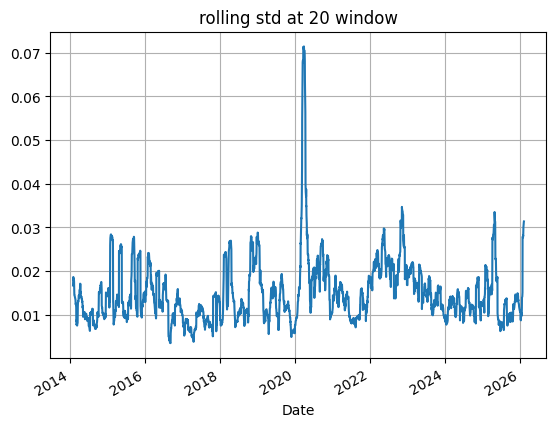

In [42]:
rolling_std = df["LogReturn"].rolling(20).std()
rolling_std.plot()
plt.grid()
plt.title('rolling std at 20 window');

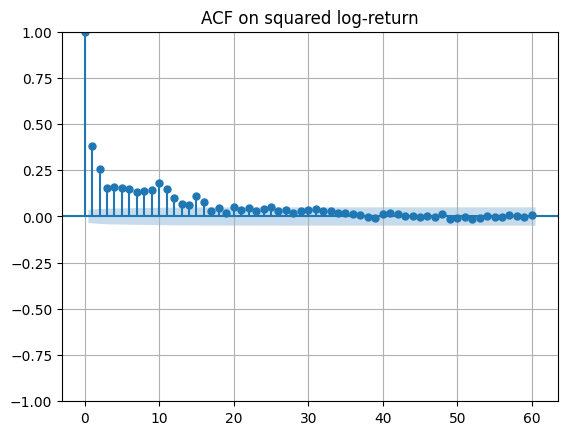

In [43]:
plot_acf((df['LogReturn'] ** 2).dropna(), lags=60)
plt.grid()
plt.title('ACF on squared log-return')
plt.show()

ACF Insight: The slow decay in the ACF of squared log-returns suggests volatility clustering and long memory in volatility (variance), a hallmark of ARCH/GARCH-type behavior.

Rolling Std Insight: Rolling standard deviation reveals time-varying volatility regimes, showing that periods of high and low variance persist over time, even when the return series itself appears random.

### Calendar Effects 

From our analysis, as ACF is mostly flat and decomposition had weak sesonality, only small calendar effect is expected.

Given our horizon of ~15 years, only week and monthly calendar effects. For yearly effect, we will end up with only 10-15 records (1 per year) are insufficient.

In [44]:
df['Day'] = df.index.day_name()
df['Month'] = df.index.month
df['Week'] = df.index.day_of_week

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df['Day'] = pd.Categorical(df['Day'], categories=order, ordered=True)

order = list(range(1, 13))
df['Month'] = pd.Categorical(df['Month'], categories=order, ordered=True)

order = list(range(1, 5))
df['Week'] = pd.Categorical(df['Week'], categories=order, ordered=True)

#### day

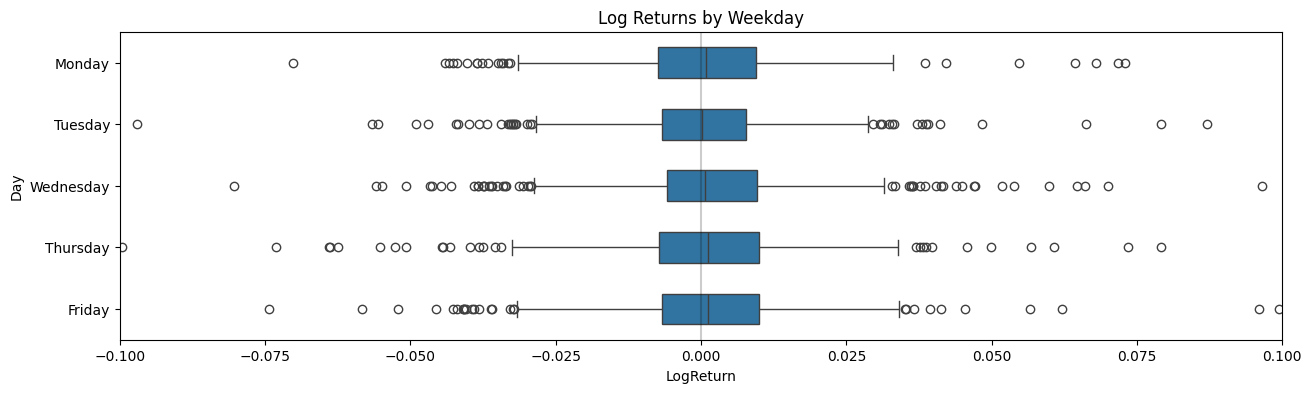

In [45]:
plt.figure(figsize=(15,4))
sns.boxplot(data=df, x='LogReturn', y ='Day', width=0.5)
plt.axvline(0, color='black', alpha=0.2)
plt.xlim(-0.1, 0.1)
plt.title('Log Returns by Weekday')
plt.show()

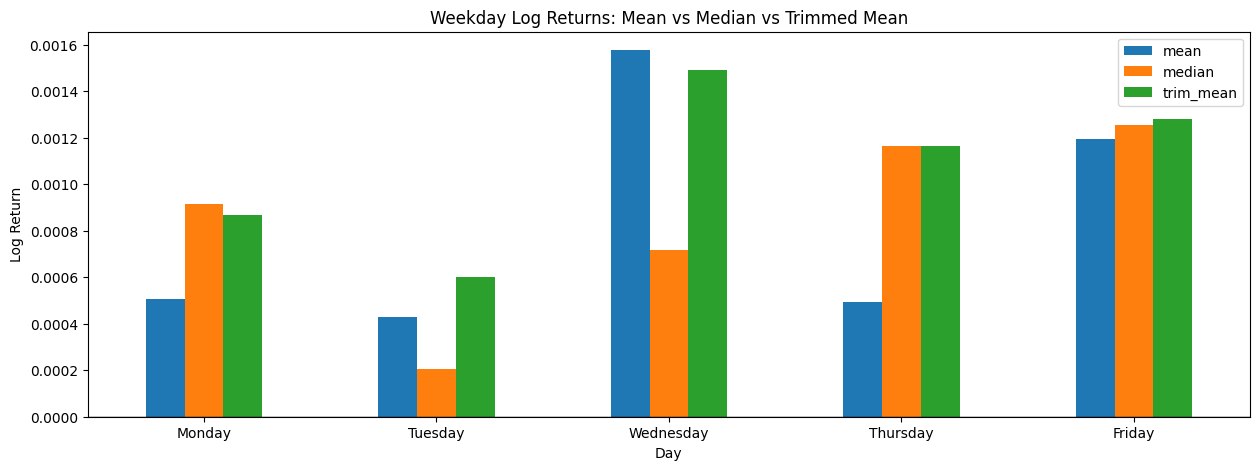

               mean    median  trim_mean
Day                                     
Monday     0.000508  0.000914   0.000866
Tuesday    0.000427  0.000204   0.000600
Wednesday  0.001577  0.000716   0.001493
Thursday   0.000493  0.001164   0.001164
Friday     0.001193  0.001253   0.001281


In [47]:
stats_df = pd.DataFrame()
stats_df['mean'] = df.groupby('Day')['LogReturn'].mean()
stats_df['median'] = df.groupby('Day')['LogReturn'].median()
stats_df['trim_mean'] = df.groupby('Day')['LogReturn'].apply(lambda x: stats.trim_mean(x, 0.1))

stats_df.plot(kind='bar', figsize=(15,5))
plt.title("Weekday Log Returns: Mean vs Median vs Trimmed Mean")
plt.ylabel("Log Return")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=0)
plt.show()

print(stats_df)

>  From boxplot, there is weekday‑specific outlier patterns and median are not at same level.

 Tuesday shows mixed signals, some positive outliers but many small or near-zero returns Possibly thin center with occasional spikes.


| Day       | Distribution Shape | Tail Behavior        | Likely Volatility | Future Behaviour (mean drift bias)                       |
| --------- | ------------------ | -------------------- | ----------------- | -------------------------------------------------------- |
| Wednesday | Right-skewed      | Positive jumps       | High              | Upward bias but jump-driven (unstable mean)              |
| Thursday  | Left-skewed        | Negative shocks      | High              | Typical strength but downside risk drags mean            |
| Monday    | Slight left skew (trimed mean ~ median ~ 2*mean)  | Mild negative tail   | Moderate          | Modest upward drift (mean underestimates typical return) |
| Tuesday   | Mild right skew (Median < Mean, but, < Trimmed-Mean)   | Small positive moves | Lower             | Weak upward drift (low signal)                           |
| Friday    | Near symmetric (all 3 close)    | Limited tail impact  | Lower             | Stable positive drift (mean reliable)                    |


In [48]:
groups = [group['LogReturn'].dropna().values 
          for name, group in df.groupby('Day')]

# ANOVA
f_stat, p_anova = stats.f_oneway(*groups)
print(f"Days effect: ANOVA p-value {p_anova:.4f}")

# Levene
w_stat, p_levene = stats.levene(*groups)
print(f"Days effect: Levene p-value {p_levene:.4f}")

Days effect: ANOVA p-value 0.6692
Days effect: Levene p-value 0.4431


Anova Test conclude that the difference in "mean" and "variance" of log returns across weekdays is insignificant. The weekday features will not significantly improve the forecasting.

#### week

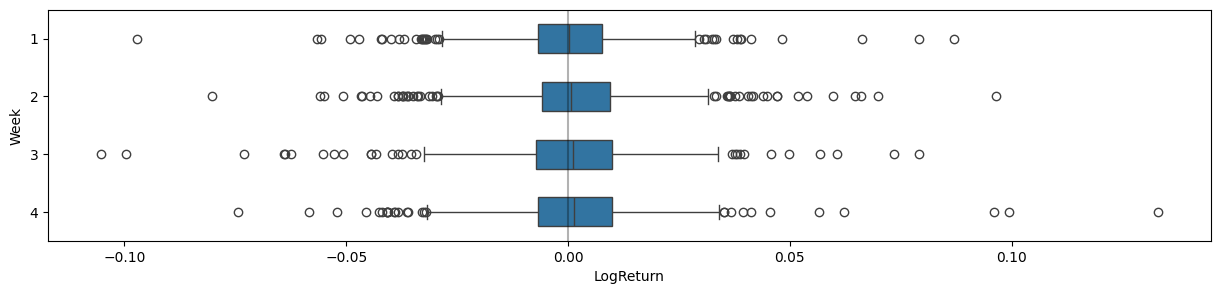

In [49]:
# box plot
plt.figure(figsize=(15, 3))
sns.boxplot(df, y='Week', x='LogReturn', width=0.5)
plt.axvline(x=0, color='black', alpha=0.3)
plt.show()

In [50]:
groups = [group['LogReturn'].dropna().values 
          for name, group in df.groupby('Week')]

# ANOVA
f_stat, p_anova = stats.f_oneway(*groups)
print(f"Day of Month effect: ANOVA p-value {p_anova:.4f}")

# Levene
w_stat, p_levene = stats.levene(*groups)
print(f"Day of Month: Levene p-value {p_levene:.4f}")

Day of Month effect: ANOVA p-value 0.5530
Day of Month: Levene p-value 0.2926


> Similar to weekdays, week no of month also have slightly different median and data (outlier spread) but Both ANOVA and Levene p-value >> 0.05 suggest that mean and variance diference are insignificant respectively.

> 

#### turn-of-month

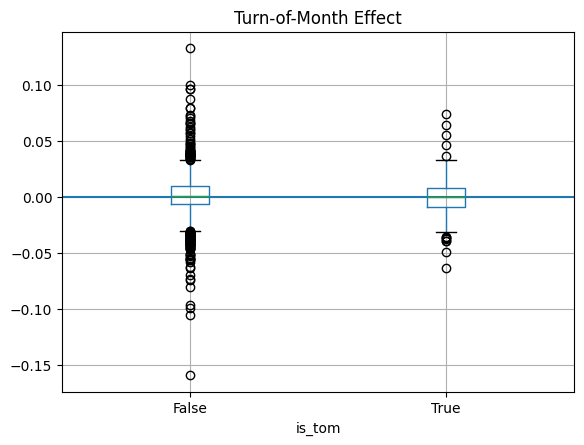

is_tom
False    0.000964
True    -0.000275
Name: LogReturn, dtype: float64

In [51]:
df['Day'] = df.index.day

# Simple version: first 3 days of month
df['is_tom'] = df['Day'] <= 3

df.boxplot(column='LogReturn', by='is_tom')
plt.axhline(0)
plt.title('Turn-of-Month Effect')
plt.suptitle('')
plt.show()

df.groupby('is_tom')['LogReturn'].mean()

> 3 turn of month has median centered, so its also insignification.

#### month

max period data is used since 10-15 entry for each month is insufficient to conclusion

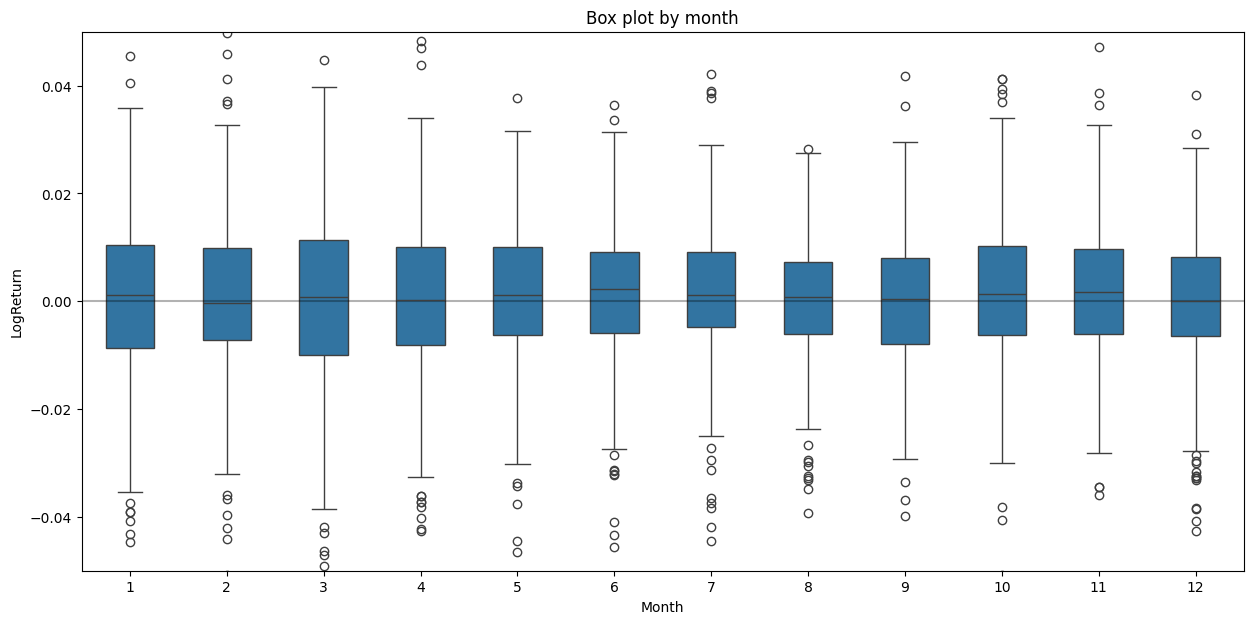

In [52]:
# box plot
plt.figure(figsize=(15, 7))
sns.boxplot(df, x='Month', y='LogReturn', width=0.5)
plt.title('Box plot by month')
plt.axhline(y=0, color='black', alpha=0.3)
plt.ylim(-0.05, 0.05)
plt.show()

In [ ]:
groups = [group['LogReturn'].dropna().values 
          for name, group in df.groupby('Month')]

# ANOVA test for constant mean 
f_stat, p_anova = stats.f_oneway(*groups)
print(f"Month of Year effect: ANOVA p-value {p_anova:.4f}")

# Levene - varying variance
w_stat, p_levene = stats.levene(*groups)
print(f"Month of Year: Levene p-value {p_levene:.4f}")


# Bartlett (optional)
b_stat, p_bartlett = stats.bartlett(*groups)
print(f"Month of Year effect: Bartlett p-value {p_bartlett:.4f}")

Month of Year effect: ANOVA p-value 0.7361
Month of Year: Levene p-value 0.0000
Month of Year effect: Bartlett p-value 0.0000


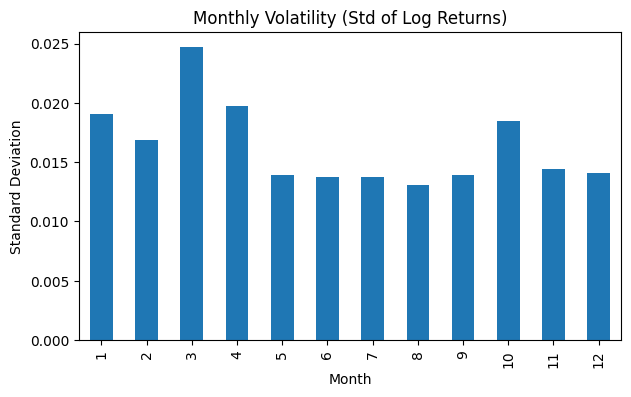

In [54]:
# Monthly volatility (std of log returns)
monthly_vol = df.groupby('Month')['LogReturn'].std()

monthly_vol.plot(kind='bar', figsize=(7,4))
plt.title("Monthly Volatility (Std of Log Returns)")
plt.ylabel("Standard Deviation")
plt.show()

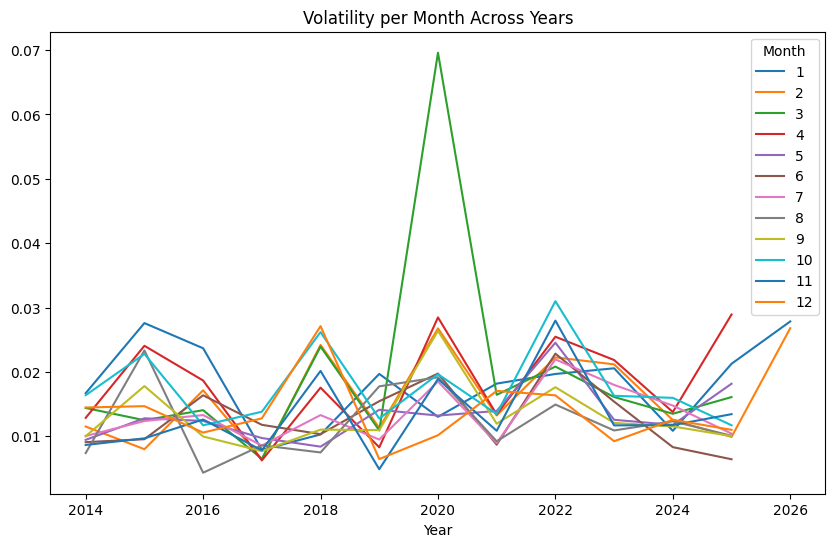

In [55]:
df['Year'] = df.index.year

monthly_yearly_vol = df.groupby(['Year','Month'])['LogReturn'].std().unstack()

monthly_yearly_vol.plot(figsize=(10,6), kind='line')
plt.title("Volatility per Month Across Years")
plt.show()

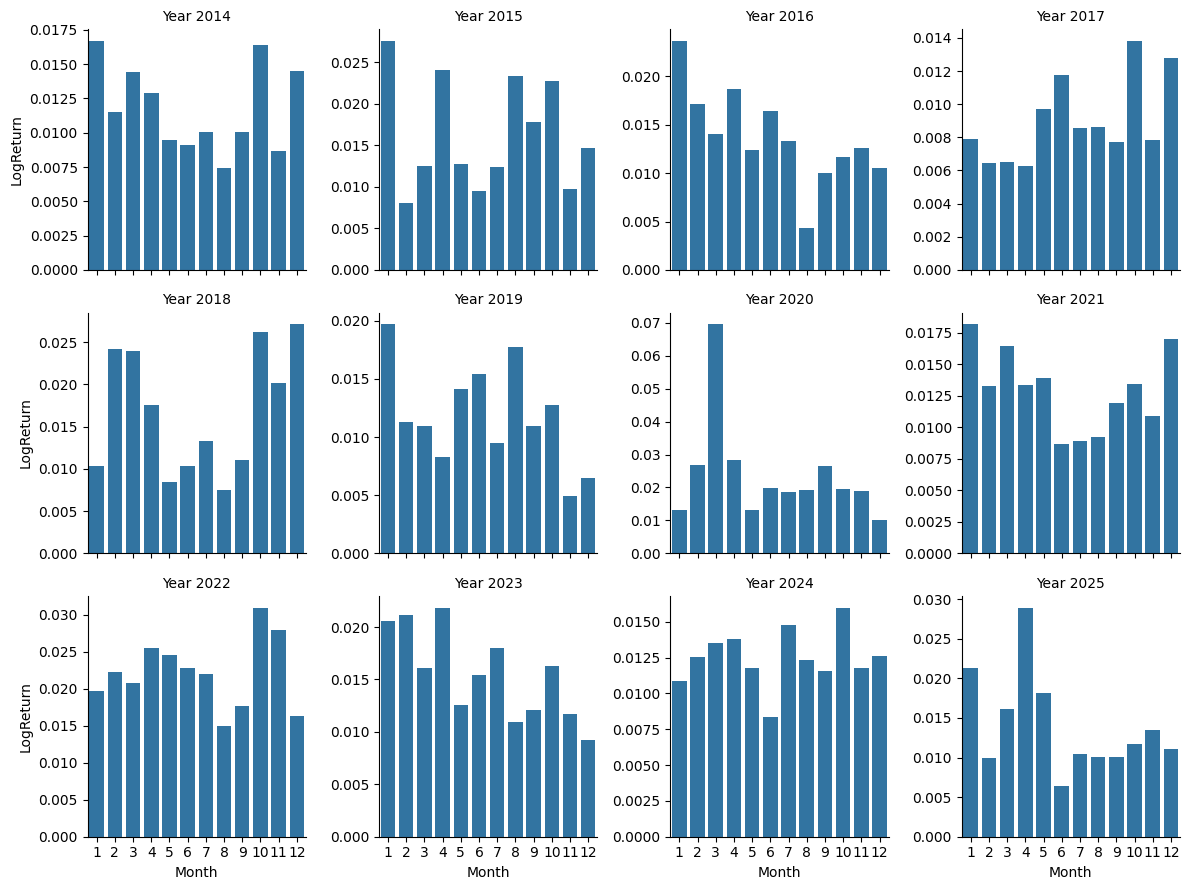

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df['Year'] = df.index.year
df['Month'] = df.index.month

g = sns.FacetGrid(df[df.index.year < 2026], col='Year', col_wrap=4, height=3, sharey=False)
g.map_dataframe(sns.barplot, x='Month', y='LogReturn', estimator='std', ci=None)
g.set_titles("Year {col_name}")
plt.show()

> Even though the levene 0 p-value suggest that variance of months are stastically different but the unstack plot of standard deviation show random behaviour in volatility over years. The difference in volatility are not seasonal or calendar effect, they're regime shift

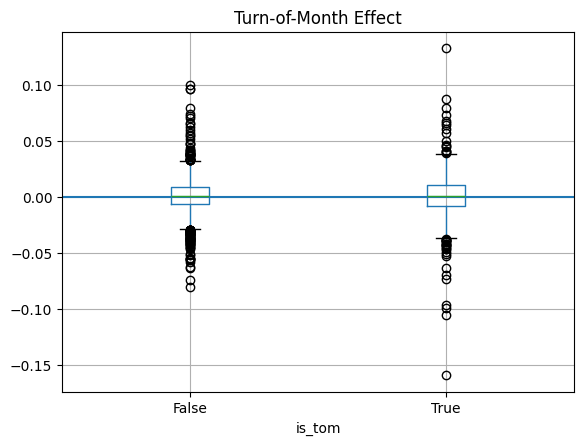

is_tom
False    0.001015
True     0.000336
Name: LogReturn, dtype: float64

In [61]:
# Simple version: first 3 days of month
df['is_tom'] = df['Month'] <= 3

df.boxplot(column='LogReturn', by='is_tom')
plt.axhline(0)
plt.title('Turn-of-Month Effect')
plt.suptitle('')
plt.show()

df.groupby('is_tom')['LogReturn'].mean()

## EDA Summary

- The price series exhibits strong trend behavior and is non-stationary in levels.
- Log-return transformation stabilizes the mean and variance, making it more suitable for modeling.
- Stationarity diagnostics suggest that log-return (or, return) are closer to weak stationarity, while price levels are not.
- ACF and PACF analysis of log-returns shows limited short-term autocorrelation, indicating a weak linear memory and justifying simple baseline models as initial benchmarks.
- Volatility is time-varying rather than constant, with clear clustering of high and low-volatility periods. This behavior is characteristic of financial time series and suggests heteroskedasticity.
- Calendar effect in mean are not any statistically present. While variance appeared different at monthly level but they are regime volatility.

Overall, the data showed expected behaviour for a daily stock price. This EDA establishes that modeling should be performed on transformed series (e.g., log-return).

## Next steps
[03_feature_engineering.ipynb](03_feature_engineering.ipynb) focuses is to construct feature representations that explicitly capture temporal dependence and volatility structure for downstream modeling.

Log-returns are weakly stationary (ACF/KPSS), and short-term autocorrelation (ACF/PACF) - so a constant mean or low-order ARMA (e.g., AR(1)) is sufficient. 

Volatility clustering in rolling standard deviation indicates conditional heteroskedasticity. GARCH and higher-order models may be explored as it captures volatility presistence. 